In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [28]:
# Data load karo (apne data ka path lagao)
train_df = pd.read_csv('../data/train.csv')

# Features aur label alag karo
X = train_df.drop('label', axis=1).values
y = train_df['label'].values

# Normalize karo (0-1 range me laao)
X = X / 255.0

# Reshape karo (CNN input: samples, height, width, channels)
X = X.reshape(-1, 28, 28, 1)

# Labels ko one-hot encode karo
y_cat = to_categorical(y, num_classes=10)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.1, random_state=42)


In [66]:
import numpy as np
X_train = np.asarray(X_train).astype("float32")
X_val   = np.asarray(X_val).astype("float32")
y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ------ Stronger Augmentation (sirf TRAIN pe) ------
train_datagen = ImageDataGenerator(
    rotation_range=15,          # thora ghumao
    width_shift_range=0.15,     # left/right shift
    height_shift_range=0.15,    # up/down shift
    shear_range=0.2,            # tilt / skew
    zoom_range=0.15,            # zoom in/out
    brightness_range=(0.8,1.2), # thori roshni dark/bright (grayscale pe bhi chalega)
    fill_mode='constant',       # blank jagah ko black se bharo
    cval=0.0
)

# (stats ki zarurat nahi but safe)
train_datagen.fit(X_train)

# Callbacks (recommended)
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, factor=0.5, min_lr=1e-4, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

batch_size = 128
epochs = 20  # augmentation ke sath thoda zyada epochs theek rehte hain




In [30]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


d:\Git Hub Project\Mnist Digit Recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
tf.keras.backend.clear_session()

# if you loaded a model, prefer: model = load_model(PATH, compile=False)

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [71]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//batch_size,
    callbacks=[lr_reduction, early_stop],
    verbose=2
)

Epoch 1/20
295/295 - 312s - 1s/step - accuracy: 0.1214 - loss: 2.2770 - val_accuracy: 0.9693 - val_loss: 0.1104 - learning_rate: 1.0000e-03
Epoch 2/20


d:\Git Hub Project\Mnist Digit Recognition\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


295/295 - 22s - 73ms/step - accuracy: 0.1250 - loss: 2.2510 - val_accuracy: 0.9695 - val_loss: 0.1106 - learning_rate: 1.0000e-03
Epoch 3/20
295/295 - 320s - 1s/step - accuracy: 0.1237 - loss: 2.2724 - val_accuracy: 0.9724 - val_loss: 0.1014 - learning_rate: 1.0000e-03
Epoch 4/20
295/295 - 22s - 74ms/step - accuracy: 0.1484 - loss: 2.2980 - val_accuracy: 0.9721 - val_loss: 0.1003 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
295/295 - 301s - 1s/step - accuracy: 0.1241 - loss: 2.2706 - val_accuracy: 0.9690 - val_loss: 0.1215 - learning_rate: 1.0000e-03
Epoch 6/20
295/295 - 38s - 129ms/step - accuracy: 0.1328 - loss: 2.2617 - val_accuracy: 0.9688 - val_loss: 0.1206 - learning_rate: 5.0000e-04
Epoch 7/20

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
295/295 - 489s - 2s/step - accuracy: 0.1247 - loss: 2.2714 - val_accuracy: 0.9655 - val_loss: 0.1246 - learning_rate: 5.0000e-04
Epoch 8/20
29

In [62]:
# Validation/Test data par prediction karo
y_pred = model.predict(X_val)                      # Model ki prediction probabilities
y_pred_labels = np.argmax(y_pred, axis=1)          # Labels nikal lo (0-9)
y_true_labels = np.argmax(y_val, axis=1)           # True labels

# Accuracy nikal lo
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Test/Validation Accuracy: {test_accuracy:.4f}")


132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step
Test/Validation Accuracy: 0.9931


132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


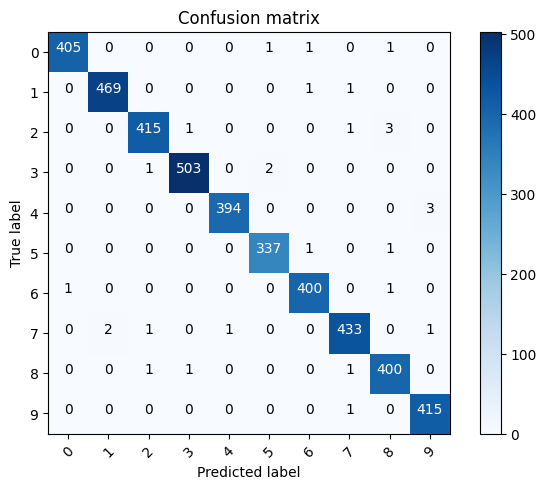

In [34]:
# Predict validation set
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_val, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Confusion matrix plot function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10))
plt.show()


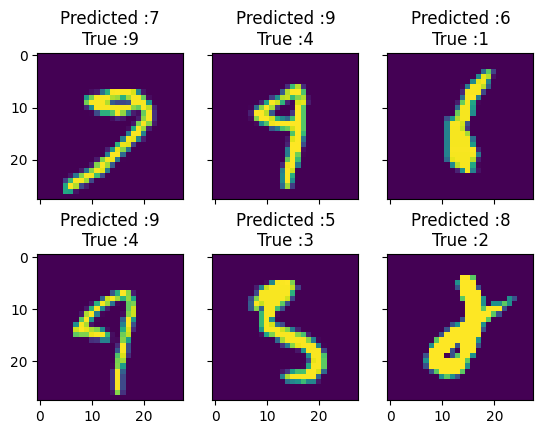

In [72]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title("Predicted :{}\nTrue :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Probabilities of wrong predictions
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-6:]

# Show top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)
plt.show()


In [36]:
model.save('outputs/mnist_model.h5') 

In [40]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_mtx, classes=range(10))  # Tumhara function
plt.savefig("confusion_matrix.png")   # Image save ho jayegi as PNG
plt.close()

In [41]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('model_accuracy.png')  # Image save ho jayegi
plt.close()


In [42]:
# Example: Randomly select 9 images from validation set aur unko show karo with predicted and true label

import random

indices = random.sample(range(len(X_val)), 9)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    img = X_val[idx].reshape(28,28)
    true_label = np.argmax(y_val[idx])
    pred_label = np.argmax(model.predict(X_val[idx].reshape(1,28,28,1)))
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('digit_predictions.png')  # Image save ho jayegi
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [47]:

import pandas as pd
test_df = pd.read_csv('../data/test.csv')  # path apne hisab se lagao
print(test_df.shape)                    # Check shape
test_df.head()


(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X_test = test_df.values           # Agar test.csv me sirf pixel columns hain
X_test = X_test / 255.0           # Normalize karo
X_test = X_test.reshape(-1, 28, 28, 1)  # Reshape for CNN input


In [50]:
from tensorflow.keras.models import load_model
model = load_model('../outputs/mnist_model.h5')


In [51]:
# Poore test set pe prediction
predictions = model.predict(X_test)
predicted_labels = predictions.argmax(axis=1)
print(predicted_labels)  # Sare test images ke predicted digits


875/875 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step
[2 0 9 ... 3 9 2]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Predicted Digit: 0


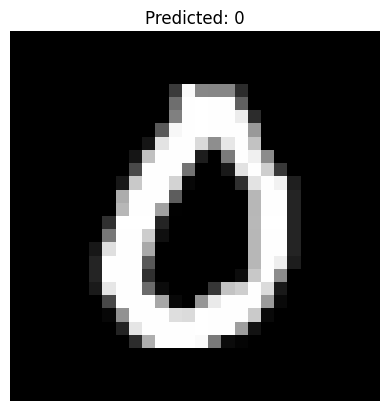

In [54]:
# Koi bhi random index choose karo, e.g., 5th image
idx = 15555
img = X_test[idx].reshape(1,28,28,1)
pred = model.predict(img)
digit = pred.argmax()
print(f"Predicted Digit: {digit}")

# Show bhi kar do
import matplotlib.pyplot as plt
plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
plt.title(f"Predicted: {digit}")
plt.axis('off')
plt.show()


In [60]:
def preprocess_array(arr):
    from PIL import Image
    import numpy as np

    # ---- make it 2D 28x28 ----
    arr = np.asarray(arr)
    arr = np.squeeze(arr)            # (28,28,1) -> (28,28)
    if arr.ndim == 3:                # just in case
        arr = arr[:, :, 0]

    # ---- scale to 0..255 float ----
    arr = arr.astype('float32')
    if arr.max() <= 1.0:
        arr *= 255.0

    # ---- auto-invert if background bright ----
    if arr.mean() > 127:
        arr = 255.0 - arr

    # ---- normalize 0..1 ----
    arr /= 255.0

    # ---- light threshold (denoise) ----
    arr = np.where(arr < 0.05, 0.0, arr)

    # ---- bbox of digit (now 2D, so where returns 2 arrays) ----
    ys, xs = np.where(arr > 0.05)
    if len(xs) == 0 or len(ys) == 0:
        arr = np.pad(arr, 4, mode='constant', constant_values=0.0)
        arr = Image.fromarray((arr * 255).astype('uint8')).resize((28, 28), Image.BILINEAR)
        arr = np.asarray(arr).astype('float32') / 255.0
        return arr.reshape(1, 28, 28, 1)

    y1, y2 = ys.min(), ys.max() + 1
    x1, x2 = xs.min(), xs.max() + 1
    crop = arr[y1:y2, x1:x2]

    # ---- pad to square ----
    h, w = crop.shape
    side = max(h, w)
    pt = (side - h)//2; pb = side - h - pt
    pl = (side - w)//2; pr = side - w - pl
    square = np.pad(crop, ((pt,pb),(pl,pr)), mode='constant', constant_values=0.0)

    # ---- resize 20x20 and pad to 28x28 ----
    img20 = Image.fromarray((square * 255).astype('uint8')).resize((20, 20), Image.BILINEAR)
    arr20 = np.asarray(img20).astype('float32') / 255.0
    arr28 = np.pad(arr20, 4, mode='constant', constant_values=0.0)

    return arr28.reshape(1, 28, 28, 1).astype('float32')


In [61]:
X_val_proc = np.vstack([preprocess_array(X_val[i]) for i in range(len(X_val))])
y_pred = model.predict(X_val_proc)


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step
